# Figure 2. Multiple DROSHA cleavage patterns
A. Illustration of multiple DROSHA cleavage patterns  
B. Cleavage Specificity and Cleavage Productivity  
C. Classification results  
D. Secondary structure difference between differentially classified miRNAs  
E. Primary sequence motifs enrichment between differentially classified miRNAs  
F. Characteristics of miRNAs with alternative cleavage 
G. Characteristics of miRNAs with nick cleavage   
H. Characteristics of miRNAs with inverted cleavage 

In [1]:
import time
today = time.strftime('%Y-%m-%d')
name = 'Seungchan Baek'
print 'Last revised by %s at %s.' % (name, today)

Last revised by Seungchan Baek at 2020-10-13.


In [2]:
home = '/casa/bsc/projects/1_DCS/2004_paper_prep/'
utilpath = '/casa/bsc/notebooks/'
%cd $home

/casa/bsc/projects/1_DCS/2004_paper_prep


In [3]:
from __future__ import division
import sys; sys.path.append(utilpath)
from util import *
from basic import gen_result_dir
resultpath = gen_result_dir('results/')
print 'resultpath:', resultpath

resultpath: results/201013/


In [4]:
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt
from matplotlib import lines, gridspec
from scipy.stats import mannwhitneyu, sem
from collections import defaultdict, Counter
%matplotlib inline

In [5]:
LIBRARIES = [ 'set1', 'set2', 'set3', 'set4', 'set5' ]

#### Import supplementary tables

In [6]:
s1 = pd.read_csv('supplementary/201012_s1_pri-info.csv', header=1, index_col=0)
s2 = pd.read_csv('supplementary/201012_s2_pri-construct.csv', header=1, index_col=0)
s5 = pd.read_csv('supplementary/201012_s5_pri-structure.csv', header=1, index_col=0)
s6 = pd.read_csv('supplementary/201012_s6_cleavage-patterns.csv', header=1, index_col=0)
print 's1:\t%s'%', '.join(list(s1.columns))
print 's2:\t%s'%', '.join(list(s2.columns)[:6])
print 's5:\t%s'%', '.join(list(s5.columns)[-10:])
print 's6:\t%s'%', '.join(list(s6.columns)[-4:])

s1:	5p mature, 5p sequence, 3p mature, 3p sequence, Note
s2:	Chr, Start, End, Strand, Construct sequence, 100way phyloP scores (pre-miRNA -/+ 100nt)
s5:	117, 118, 119, 120, 121, 122, 123, 124, 125, symbolized structure
s6:	Relative position from miRBase site, Cleavage Specificity, Cleavage Imbalance, Cleavage type


In [7]:
def get_pre_position(pri):
    constructseq = s2.loc[pri, 'Construct sequence'].replace('T','U')
    seq5p = s1.loc[pri, '5p sequence']
    seq3p = s1.loc[pri, '3p sequence']
    if seq5p=='n.a.' or constructseq.find(seq5p)==-1:
        prestart = 0
    else:
        prestart = constructseq.find(seq5p)+1
    if seq3p=='n.a.' or constructseq.find(seq3p)==-1:
        preend = 125
    else:
        preend = constructseq.rfind(seq3p)+len(seq3p)
    return prestart, preend

In [8]:
allpris = s1.index
preposition = { pri:get_pre_position(pri) for pri in allpris }
print len(preposition)

1881


In [9]:
mirtrons = [ pri for pri in allpris if s1.loc[pri,'Note'].find('Mirtron')>=0 ]
capped = [ pri for pri in allpris if s1.loc[pri,'Note'].find('Capped miRNA')>=0 ]
drosensitive = [ pri for pri in allpris if s1.loc[pri,'Note'].find('DROSHA KO-sensitive')>=0 ]
fclipdetected = [ pri for pri in allpris if s1.loc[pri,'Note'].find('fCLIP site-determined')>=0 ]
dbmirs = [ pri for pri in allpris if s1.loc[pri,'Note'].find('MirGeneDB')>=0 ]
print len(mirtrons), len(capped), len(drosensitive), len(fclipdetected), len(dbmirs)

239 11 157 281 519


In [10]:
constseqs = dict(s2['Construct sequence'])
print len(constseqs)

1881


# A. Illustration of multiple DROSHA cleavage patterns

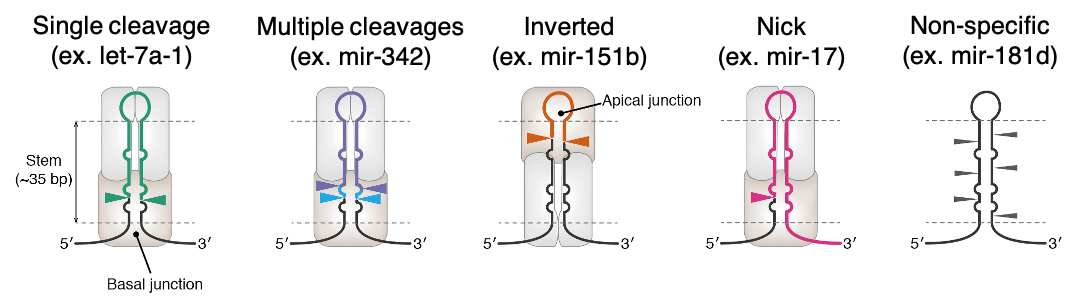

In [11]:
from IPython.display import Image
Image(filename='supplementary/figures/fig2A.png', width=700)

# B.  Cleavage Specificity and Cleavage Productivity

In [12]:
pros = s6['Cleavage Productivity'].to_dict()
s6sort = s6.sort_values('Cleavage Specificity')
spes = s6sort[~s6sort.index.duplicated(keep='last')]['Cleavage Specificity'].to_dict()
overlap = [ mir for mir in pros if mir in spes ]
print len(overlap)

1816


In [13]:
mirset = [ allpris, drosensitive, mirtrons ]
fcolors = [ '#cbcbcb', '#1b9e77', '#666666' ]
ecolors = [ '#ababab', '#01665e', '#252525' ]
labels = [ 'All miRNAs', 'Canonical (Kim et al., 2016)', 'Mirtrons (Ladewig et al., 2012)' ]
sizes = [ 6, 10, 10 ]
zs = [ 2, 3, 2 ]
xmin, xmax, xo = 0, 5.7, .15
ymin, ymax, yo = 0, 1, .03
xcut, ycut = 1.4, .42
shade = '#a1d99b'

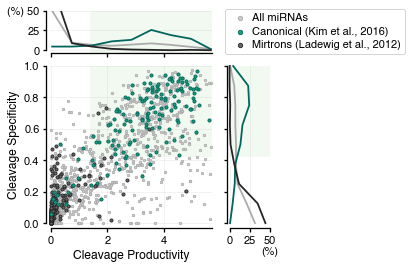

In [14]:
fig = plt.figure(figsize=(4,4))
gs = gridspec.GridSpec(2, 2, width_ratios=(4,1), height_ratios=(1,4))
ax1 = fig.add_subplot(gs[0]); ax2 = fig.add_subplot(gs[2]); ax3 = fig.add_subplot(gs[3])
fig.subplots_adjust(wspace=.1, hspace=.08)
for mirs, fcolor, ecolor, label, s, z in zip(mirset, fcolors, ecolors, labels, sizes, zs):
    xs = [ pros[mir] for mir in mirs if mir in s6.index ]
    ys = [ spes[mir] for mir in mirs if mir in s6.index ]
    xs1, ys1 = zip(*[ (x,y) for x,y in zip(xs,ys) if xmin<=x<xmax and ymin<=y<ymax])
    ax2.scatter(xs1, ys1, s=s, color=fcolor, lw=.8, edgecolor=ecolor, zorder=z, 
                label='%s'%(label))#,len(xs)))
    vs, ts = np.histogram(xs, bins=np.linspace(xmin-xo*2, xmax+xo*2, 10))
    ax1.plot((ts[1:]+ts[:-1])/2, vs/vs.sum()*100, color=ecolor, lw=1.8)
    vs, ts = np.histogram(ys, bins=np.linspace(ymin-yo*2, ymax+yo*2, 10))
    ax3.plot(vs/vs.sum()*100, (ts[1:]+ts[:-1])/2, color=ecolor, lw=1.8)

ax1.set_xticklabels([]); ax3.set_yticklabels([])
ax2.set_xlim(xmin-xo, xmax+xo); ax2.spines['bottom'].set_bounds(xmin, xmax)
ax1.set_xlim(xmin-xo, xmax+xo); ax1.spines['bottom'].set_bounds(xmin, xmax)
ax2.set_ylim(ymin-yo, ymax+yo); ax2.spines['left'].set_bounds(ymin, ymax)
ax3.set_ylim(ymin-yo, ymax+yo); ax3.spines['left'].set_bounds(ymin, ymax)

ax1.set_yticks([0,25,50]); ax3.set_xticks([0,25,50])
ax1.set_yticklabels([0,25,'(%) 50']); ax3.set_xticklabels([0,25,'50\n(%)'])
ax1.spines['left'].set_bounds(0, 50); ax1.set_ylim(-3, 50)
ax3.spines['bottom'].set_bounds(0, 50); ax3.set_xlim(-3, 50)
ax2.set_xlabel('Cleavage Productivity', fontsize=12)
ax2.set_ylabel('Cleavage Specificity', fontsize=12)

gr1 = plt.Rectangle((xmin-xo/4,-1), xmax+xo/4, 81, fc='w'); ax1.add_patch(gr1)
ax1.yaxis.grid(ls='-', alpha=.2, clip_path=gr1)
gr2 = plt.Rectangle((xmin-xo/4,ymin-yo/4), xmax+xo/4, ymax+yo/4, fc='w'); ax2.add_patch(gr2)
ax2.grid(ls='-', alpha=.2, clip_path=gr2)
gr3 = plt.Rectangle((-.5,ymin-yo/4), 51, ymax+yo/4, fc='w'); ax3.add_patch(gr3)
ax3.xaxis.grid(ls='-', alpha=.2, clip_path=gr3)
leg = ax2.legend(prop={'size':11}, loc=(1.05,1.04), handletextpad=.05, labelspacing=.3)
for handle in leg.legendHandles:
    handle.set_sizes([20])

sq1 = plt.Rectangle((xcut,-3), xmax-xcut, 88, fc=shade, alpha=.15); ax1.add_patch(sq1)
sq2 = plt.Rectangle((xcut,ycut),xmax-xcut,ymax-ycut,fc=shade,alpha=.15); ax2.add_patch(sq2)
sq3 = plt.Rectangle((-1,ycut), 52, ymax-ycut, fc=shade, alpha=.15); ax3.add_patch(sq3)

#fig.savefig(resultpath + '200908_f2b__cleavage_pattern_v2.pdf')#,dpi=300)

In [15]:
mirl = 'hsa-mir-142 hsa-mir-17 hsa-mir-374b hsa-mir-15a hsa-mir-181b-1 hsa-mir-181b-2'.split()
for mir in mirl:
    print '%s\t%.3f\t%.3f' % (mir, pros[mir], spes[mir])

hsa-mir-142	2.476	0.448
hsa-mir-17	2.610	0.413
hsa-mir-374b	0.073	0.154
hsa-mir-15a	0.956	0.286
hsa-mir-181b-1	0.335	0.504
hsa-mir-181b-2	0.150	0.133


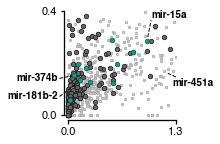

In [16]:
sizes = [ 6, 20, 20 ]
zs = [ 2, 3, 2 ]
fig, ax = plt.subplots(1,1, figsize=(2,2))
for mirs, fcolor, ecolor, label, s, z in zip(mirset, fcolors, ecolors, labels, sizes, zs):
    xs = [ pros[mir] for mir in mirs if mir in s6.index ]
    ys = [ spes[mir] for mir in mirs if mir in s6.index ]
    xs1, ys1 = zip(*[ (x,y) for x,y in zip(xs,ys) if xmin<=x<1.3 and ymin<=y<.4])
    ax.scatter(xs1, ys1, s=s, color=fcolor, lw=.8, edgecolor=ecolor, zorder=z, 
                label='%s'%(label))
mirl = 'hsa-mir-374b hsa-mir-15a hsa-mir-181b-2 hsa-mir-451a'.split()
xs = [ pros[mir] for mir in mirl if mir in s6.index ]
ys = [ spes[mir] for mir in mirl if mir in s6.index ]
ax.text(1, .375, 'mir-15a',weight='bold'); ax.plot([.96,1],[.3,.365],'k--',lw=1)
ax.text(1.25,.11,'mir-451a', weight='bold'); ax.plot([1.2,1.4],[.16,.13],'k--',lw=1)
ax.text(-.12, .06, 'mir-181b-2', weight='bold', ha='right')
l = lines.Line2D([-.1,.15],[.07,.13],ls='--',c='k',lw=1); l.set_clip_on(False); ax.add_line(l)
ax.text(-.12, .13, 'mir-374b', weight='bold', ha='right')
l = lines.Line2D([-.1,.05],[.14,.15],ls='--',c='k',lw=1); l.set_clip_on(False); ax.add_line(l)
xs1, ys1 = zip(*[ (x,y) for x,y in zip(xs,ys) if xmin<=x<xmax and ymin<=y<ymax])
ax.set_xlim(-.04, 1.3); ax.spines['bottom'].set_bounds(0,1.3)
ax.set_ylim(-.02, .4); ax.spines['left'].set_bounds(0,.4)
ax.set_xticks([0,1.3])
ax.set_yticks([0,.4])
#fig.savefig(resultpath + '200908_f2b__cleavage_pattern_sub.pdf')

# C. Classification results

In [17]:
single = set(s6[s6['Cleavage type']=='single'].index)
multi = set(s6[s6['Cleavage type']=='multiple'].index)
inverted = set(s6[s6['Cleavage type']=='inverted'].index)
nick5 = set(s6[s6['Cleavage type']=='nick5'].index)
nick3 = set(s6[s6['Cleavage type']=='nick3'].index)
nick = list(nick5) + list(nick3)
nonspec = set(s6[s6['Cleavage type']=='non-specific'].index)
dcsmirs = list(single) + list(multi)
nodcs = list(inverted) + list(nick) + list(nonspec)
print 'Productive: %s, Unproductive: %s' % (len(dcsmirs), len(nodcs))
print 'Single: %s, Multiple: %s, Inverted: %s, Nick: %s, Non-specific: %s'\
% (len(single), len(multi), len(inverted), len(nick), len(nonspec))
print "5p nick: %s, 3p nick: %s" % (len(nick5), len(nick3))

Productive: 512, Unproductive: 1304
Single: 445, Multiple: 67, Inverted: 156, Nick: 107, Non-specific: 1041
5p nick: 72, 3p nick: 35


In [18]:
data = map(len, [single, multi, nick5, nick3, inverted, nonspec])
colors = '#1b9e77 #7570b3 #e7298a #e7298a #d95f02 #757575'.split()
labels = [ 'Single', 'Alternative', '5p nick', '3p nick', 'Inverted', 'No processing' ]
data2 = [len(dcsmirs)/len(overlap),(len(nick)+len(inverted))/len(overlap)]
lw = 1.3
stangle = 100

Text(2.6,-0.8,u'Unproductive processing\n(n=263, 14%)')

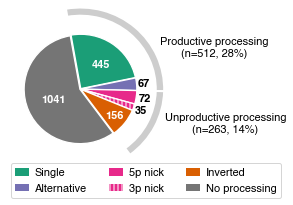

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(2.5,2.5))
ps,ts = ax.pie(data, colors=colors, explode=[.01]*len(data), counterclock=False, 
               startangle=stangle, wedgeprops={'linewidth':lw,'edgecolor':'w'})
ps[3].set_hatch('|||')
ax.text(-.7,-.25,len(nonspec),fontsize=11,color='w',weight='bold')
ax.text(.2,.4,len(single),fontsize=11,color='w',weight='bold')
ax.text(.45,-.54,len(inverted),fontsize=11,color='w',weight='bold')
ax.text(1.03,.05,len(multi),fontsize=11,color='k',weight='bold')
ax.text(1.05,-.23,len(nick5),fontsize=11,color='k',weight='bold')
ax.text(.97,-.45,len(nick3),fontsize=11,color='k',weight='bold')
lgd = plt.legend(ps,labels,loc=(0, -.3),prop={'size':11},
                 handlelength=1.3,ncol=3,handletextpad=.5)
for p in lgd.get_patches():
    p.set_linewidth(0)

ax.pie(data2, radius=1.5, startangle=stangle,counterclock=False,colors=['#cdcdcd','#cdcdcd'],
       wedgeprops={'width':.15, 'edgecolor':'w', 'linewidth':2})
ax.text(2.4,.6,'Productive processing\n(n=512, 28%)',fontsize=11,ha='center')
ax.text(2.6,-.8,'Unproductive processing\n(n=263, 14%)',fontsize=11,ha='center')
#fig.savefig(resultpath + '200908_f2c__cleavage_type_classification_v2.pdf',
#            box_extra_artist=(lgd,))

# D. Secondary structure difference between differentially classified miRNAs

In [20]:
def get_str_info(mir):
    ctinfo = [ (int(i),pair) for i,pair in s5.iloc[:,:125].loc[mir].items() ]
    return ctinfo

In [21]:
def adjust_ct(strinfo, ajs, aje):
    newinfo = [ 1 if i<=ajs<pair or 0<pair<=ajs<i else 0 for i,pair in strinfo ] 
    return zip(range(1,126), newinfo)

In [22]:
minss = 1
optiaj = 22

In [23]:
apicaljcs = {}
for mir in overlap:
    ps, pe = preposition[mir]
    constseq = constseqs[mir]
    strinfo = get_str_info(mir)
    usteml, ajpos = find_apical_junction(mir, minss, ps, pe, constseq, strinfo, optiaj)
    if usteml:
        apicaljcs[mir] = ajpos
print len(apicaljcs)
strtmirs = sorted(apicaljcs.keys())

1807


In [24]:
optibj = 36
lastunp = 3.5

In [25]:
basaljcs = {}
for mir in strtmirs:
    ajst = apicaljcs[mir][0]
    strinfo = get_str_info(mir)
    lsteml, bjpos = find_basal_junction(mir, strinfo, minss, ajst, lastunp, optibj, 1)
    if lsteml:
        basaljcs[mir] = bjpos
print len(basaljcs)
stemlens = { m:apicaljcs[m][0]-basaljcs[m][0]+1 for m in strtmirs if m in basaljcs }

1807


In [26]:
bpfreq5 = pd.DataFrame(index=overlap, columns=range(-125,126))
bpfreq3 = pd.DataFrame(index=overlap, columns=range(-125,126))
for mir in strtmirs:
    ajst, ajen = apicaljcs[mir]
    strinfo = adjust_ct(get_str_info(mir), ajst, ajen)
    bpfreq5.loc[mir] = pd.Series({ajst-i+1:p for i,p in strinfo})
    bpfreq3.loc[mir] = pd.Series({i-ajen+1:p for i,p in strinfo})
bpfreq5 = bpfreq5[bpfreq5.fillna(0).sum(axis=1)>0]
bpfreq3 = bpfreq3[bpfreq3.fillna(0).sum(axis=1)>0]
print len(bpfreq5), len(bpfreq3)

1807 1807


In [27]:
xmin, xmax = 1, 45
xpos = np.arange(xmin, xmax+1)
ls =  [ dcsmirs, nick, inverted, nonspec ]
labels = [ 'Productive processing', 'Nick processing', 'Inverted processing', 'No processing' ]
values = [ bpfreq5[xpos].reindex(l).mean()*100 for l in ls ]
ls2 = [ [m for m in l if m in stemlens] for l in ls ]
values2 = [ [ len([m for m in l if stemlens[m]==x])/len(l)*100 for x in xpos ] for l in ls2 ]
colors = '#1b9e77 #e7298a #d95f02 #242424'.split()
zs = [4,2,3,2]

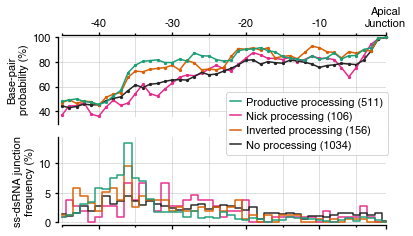

In [28]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(6,3.5))

for vs1,vs2,color,z,label,l,i in zip(values,values2,colors,zs,labels,ls,range(4)):
    n = len([m for m in l if m in strtmirs])
    ax1.plot(xpos, vs1, color=color, zorder=z, label='%s (%s)'%(label,n))
    ax1.scatter(xpos, vs1, color=color, zorder=z, s=5)
    ax2.step(xpos, vs2, color=color, zorder=z, where='mid', alpha=8) 
    
for ax in [ax1,ax2]:
    ax.set_xlim(xmin-1, xmax+.5)
    ax.set_xticks([1]+range(10,41,10)); ax.set_xticks(range(5,46,10), minor=True)
    ax.tick_params(width=1.3, which='both')
    ax.invert_xaxis()
    ax.grid(ls='-', which='both')
    
ax1.set_xticklabels(['Apical\nJunction']+range(-10,-41,-10)); ax2.set_xticklabels([])
ax1.set_ylabel('Base-pair\nprobability (%)', fontsize=11)
ax1.xaxis.tick_top(); ax1.xaxis.set_label_position('top')
ax1.set_ylim(30,102)
ax1.spines['top'].set_visible(True); ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_bounds(30,100); ax1.spines['top'].set_bounds(1,45)
ax1.legend(loc=(.5,-.35), handlelength=1, handletextpad=.5, labelspacing=.4, prop={'size':11})
sq1 = plt.Rectangle((.9,35), xmax, 65.5, fc='w')
ax1.add_patch(sq1); ax1.grid(clip_path=sq1, which='both', ls='-', alpha=.5)

ax2.set_ylabel('ss-dsRNA junction\nfrequency (%)')
ax2.set_ylim(-.5, 14.5); ax2.spines['left'].set_bounds(0,14.5)
ax.spines['bottom'].set_bounds(1,45)
sq2 = plt.Rectangle((.9,-.1), xmax, 14.6, fc='w')
ax2.add_patch(sq2); ax2.grid(clip_path=sq2, which='both', ls='-', alpha=.5)
ax2.set_zorder(-1)
fig.subplots_adjust(hspace=.15)
#fig.savefig(resultpath + '201007_f2d__secondary_structure.pdf')#,dpi=300)

#### Suppl

In [29]:
xmin, xmax = 1, 45
xpos = np.arange(xmin, xmax+1)
ls =  [ dcsmirs, nick5, nick3 ]
labels = [ 'Productive processing', "5' nick processing", "3' nick processing" ]
values = [ bpfreq5[xpos].reindex(l).mean()*100 for l in ls ]
ls2 = [ [m for m in l if m in stemlens] for l in ls ]
values2 = [ [ len([m for m in l if stemlens[m]==x])/len(l)*100 for x in xpos ] for l in ls2 ]
colors = '#1b9e77 #e7298a #762a83'.split()
zs = [4,2,3,2]

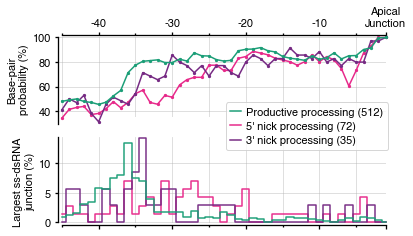

In [30]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(6,3.5))

for vs1,vs2,color,z,label,l,i in zip(values,values2,colors,zs,labels,ls,range(4)):
    ax1.plot(xpos, vs1, color=color, zorder=z, label='%s (%s)'%(label,len(l)))
    ax1.scatter(xpos, vs1, color=color, zorder=z, s=5)
    ax2.step(xpos, vs2, color=color, zorder=z, where='mid', alpha=8) 
    
for ax in [ax1,ax2]:
    ax.set_xlim(xmin-1, xmax+.5)
    ax.set_xticks([1]+range(10,41,10)); ax.set_xticks(range(5,46,10), minor=True)
    ax.tick_params(width=1.3, which='both')
    ax.invert_xaxis()
    ax.grid(ls='-', which='both')
    
ax1.set_xticklabels(['Apical\nJunction']+range(-10,-41,-10)); ax2.set_xticklabels([])
ax1.set_ylabel('Base-pair\nprobability (%)', fontsize=11)
ax1.xaxis.tick_top(); ax1.xaxis.set_label_position('top')
ax1.set_ylim(30,102)
ax1.spines['top'].set_visible(True); ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_bounds(30,100); ax1.spines['top'].set_bounds(1,45)
ax1.legend(loc=(.5,-.3), handlelength=1, handletextpad=.5, labelspacing=.4, prop={'size':11})
sq1 = plt.Rectangle((.9,35), xmax, 65.5, fc='w')
ax1.add_patch(sq1); ax1.grid(clip_path=sq1, which='both', ls='-', alpha=.5)

ax2.set_ylabel('Largest ss-dsRNA\njunction (%)')
ax2.set_ylim(-.5, 14.5); ax2.spines['left'].set_bounds(0,14.5)
ax.spines['bottom'].set_bounds(1,45)
sq2 = plt.Rectangle((.9,-.1), xmax, 14.6, fc='w')
ax2.add_patch(sq2); ax2.grid(clip_path=sq2, which='both', ls='-', alpha=.5)
ax2.set_zorder(-1)
fig.subplots_adjust(hspace=.15)
#fig.savefig(resultpath + '200909_f2l__secondary_structure_53nick.pdf')#,dpi=300)

# E. Primary sequence motifs enrichment between differentially classified miRNAs

In [31]:
seq5tbl, seq3tbl = pd.DataFrame(columns=range(-20,30)), pd.DataFrame(columns=range(-25,30))
str5tbl, str3tbl = pd.DataFrame(columns=range(-20,30)), pd.DataFrame(columns=range(-25,30))

In [32]:
def mirbase_to_relative_pos(mir, c5, c3):
    ps, pe, strand = s2.loc[mir, ['Start','End','Strand']]
    if strand=='+':
        return c5-ps+1, c3-ps+1
    return pe-c3+1, pe-c5+1

In [33]:
for mir in strtmirs:
    ps, pe = get_pre_annot(mir)[1:3]
    rps, rpe = mirbase_to_relative_pos(mir, ps, pe)
    priseq = constseqs[mir].replace('T','U')
    strt = [ 1 if s=='M' else 0 for s in s5.loc[mir,'symbolized structure'] ]
    seq5, str5 = priseq[max(0,rps-21):rps+29][::-1], strt[max(0,rps-21):rps+29][::-1]
    seq3, str3 = priseq[rpe-30:min(125,rpe+25)], strt[rpe-30:min(125,rpe+25)]
    pos5, pos3 = range(-20,30)[::-1], range(-25,30)[::-1]
    seq5tbl.loc[mir] = pd.Series(dict(zip(pos5,seq5)[::-1]))
    seq3tbl.loc[mir] = pd.Series(dict(zip(pos3,seq3)[::-1]))
    str5tbl.loc[mir] = pd.Series(dict(zip(pos5,str5)[::-1]))
    str3tbl.loc[mir] = pd.Series(dict(zip(pos3,str3)[::-1]))

In [34]:
seq5tbl = seq5tbl.fillna('')
str5tbl = str5tbl.fillna('')
seq3tbl = seq3tbl.fillna('')
str3tbl = str3tbl.fillna('')

In [35]:
def find_ug(mir, pos):
    seq = ''.join(seq5tbl.loc[mir,range(pos,pos+2)].fillna(''))
    return seq=='UG'

In [36]:
def find_ugu(mir, pos):
    seq = ''.join(seq5tbl.loc[mir,range(pos,pos+3)])
    return (seq=='UGU' or seq=='GUG')

In [37]:
def find_cnnc(mir, pos):
    seq = ''.join(seq3tbl.loc[mir,range(pos-3,pos+1)].fillna(''))
    return bool(re.search('C[A-Z][A-Z]C', seq))

In [38]:
def find_ghg(mir, pos): # 3'-GHN-5' + match-mismatch-match
    seq = ''.join(seq3tbl.loc[mir,range(pos-2,pos+1)].fillna(''))
    st = str3tbl.loc[mir,range(pos-2,pos+1)].tolist()
    return (bool(re.search('G[^G][A-Z]', seq)) and st==[1,0,1])

In [39]:
motifs = [ 'CNNC', 'UG', 'GHG', 'UGU' ]
ranges = { 'UG':range(-20,-10),'UGU':range(15,25),'GHG':range(-10,0), 'CNNC':range(-25,-15) }
funcs = { 'UG':find_ug, 'UGU':find_ugu, 'GHG':find_ghg, 'CNNC':find_cnnc }

In [40]:
ysd = defaultdict(lambda: [0]*10)
for mir in strtmirs:
    for i in range(10):
        for motif in motifs:
            ysd[motif][i]+=int(funcs[motif](mir,ranges[motif][i]))

/casa/bsc/.local/lib/python2.7/site-packages/pandas/core/indexing.py:1020: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


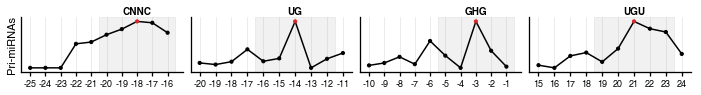

In [41]:
fig, axes = plt.subplots(1,4,figsize=(12,1))
for motif,ax in zip(motifs,axes.flatten()):
    ax.plot(ranges[motif], ysd[motif], color='k')
    maxpos = max(ranges[motif], key=lambda x:ysd[motif][ranges[motif].index(x)])
    cs = ['tab:red' if y==max(ysd[motif]) else 'k' for y in ysd[motif]]
    ax.scatter(ranges[motif], ysd[motif], color=cs, s=10, zorder=3)
    ax.axvspan(maxpos-2.5,maxpos+2.5,color='#bababa',alpha=.2)
    ax.set_xticks(ranges[motif]); ax.set_xticklabels(ranges[motif],fontsize=9)
    ax.set_yticks([])
    ty = max(ysd[motif])+(max(ysd[motif])-min(ysd[motif]))*.15
    ax.text(maxpos,ty,motif,ha='center',weight='bold')
    ax.grid(ls='-',lw='.5')
axes[0].set_ylabel('Pri-miRNAs')
fig.subplots_adjust(wspace=.05)
#fig.savefig(resultpath + '200908_f2e__primary_sequence_sub.pdf')#,dpi=300)

In [42]:
bsfreq, window = {}, {}
for motif in motifs:
    bsfreq[motif] = dict(zip(ranges[motif],np.array(ysd[motif])/len(strtmirs)))
    maxpos = max(ranges[motif], key=lambda x:ysd[motif][ranges[motif].index(x)])
    window[motif] = range(maxpos-2,maxpos+3)

In [43]:
mirls =  [ dcsmirs, nick, inverted, nonspec ]

In [44]:
entbls = defaultdict(lambda: pd.DataFrame())
for motif in motifs:
    for i, mirl in enumerate(mirls):
        mirl = [ m for m in mirl if m in strtmirs ]
        for pos in window[motif]:
            freq = len([m for m in mirl if funcs[motif](m,pos)])/len(mirl)
            if freq==0:
                entbls[motif].loc[i,pos] = -1
            else:
                entbls[motif].loc[i,pos] = np.log2(freq/bsfreq[motif][pos])
                #entbls[motif].loc[i,pos] = np.log2(freq/np.average(bsfreq[motif].values()))

In [45]:
labels = [ 'Productive processing', 'Nick processing', 'Inverted processing', 'No processing' ]
arms = { 'UG':'5p', 'UGU':'5p', 'GHG':'3p', 'CNNC':'3p' }
cmap = custom_cmap(['#404040','#f0f0f0','#f0f0f0','#a50f15'], nspace=6)
emax, emin = 1, -1

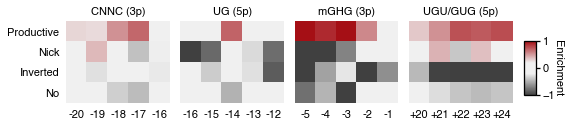

In [46]:
fig, axes = plt.subplots(1, 4, figsize=(8,1.5), sharey=True)
for motif,ax in zip(motifs,axes):
    im = ax.pcolor(entbls[motif],cmap=cmap,vmax=1,vmin=-1)
    ax.set_xticks(np.arange(5)+.5)
    ax.set_xticklabels([i if i<0 else '+%s'%(i+1) for i in window[motif]])
    ax.tick_params(left='off',bottom='off')
    ax.spines['left'].set_visible(False); ax.spines['bottom'].set_visible(False)
    ax.set_title('%s (%s)'%(motif.replace('UGU','UGU/GUG').replace('GHG','mGHG'),arms[motif]))
ax = axes[0]
ax.invert_yaxis()
ax.set_yticks(np.arange(len(mirls))+.5)
ax.set_yticklabels(['Productive','Nick','Inverted','No'], fontsize=11)
axcb = fig.add_axes([.92,.2,.02,.5])
cb = plt.colorbar(im, cax=axcb); cb.set_ticks([-1,0,1])
fig.text(.97,.45,'Enrichment',va='center',rotation=270,fontsize=11)
fig.subplots_adjust(wspace=.1)
#fig.savefig(resultpath + '200908_f2e__primary_sequence.pdf')#,dpi=300)

# F. Characteristics of miRNAs with alternative cleavage

In [47]:
optibj = 13
optiug = 14
optighg = 7

In [48]:
def clv_to_relative_pos(mir, c5, c3):
    ps, pe, strand = s2.loc[mir, ['Start','End','Strand']]
    if strand=='+':
        return c5-ps+1, c3-ps+1
    return pe-c5+1, pe-c3+1

In [49]:
s6sort = s6.sort_values('Cleavage Specificity', ascending=False)
majorcs = {}
for mir in dcsmirs:
    c5, c3 = s6sort.loc[[mir],["5' cleavage site","3' cleavage site"]].iloc[0]
    majorcs[mir] = clv_to_relative_pos(mir, c5, c3)
print len(majorcs)

512


In [50]:
bjposes = {}
for mir in dcsmirs:
    if mir not in strtmirs:
        bjposes[mir] = 0; continue
    cs, ce = majorcs[mir]
    lsinfo = [ (s,e) for s,e in get_str_info(mir) if s<cs<e ][::-1]
    ls1st5, ls1st3 = lsinfo[0]
    us1st3 = [ (s,e) for s,e in get_str_info(mir) if cs<=s<e ][0][1]
    init = min(cs-ls1st5, ls1st3-us1st3)    
    bjs = zip(*list_basal_jcs(lsinfo, minss, lastunp, init))[0]  
    if bjs:
        bjposes[mir] = min(bjs[::-1], key=lambda x:abs(x-optibj))
    else:
        bjposes[mir] = 0

In [51]:
ugposes = {}
for mir in dcsmirs:
    cs, ce = majorcs[mir]
    constseq = constseqs[mir].replace('T','U')
    conststr = s5.loc[mir, 'symbolized structure']
    ugs = [ count_len(conststr[i+1:cs-1])+1 
            for i in range(cs-3) if constseq[i:i+2]=='UG' ]
    if ugs:
        ugposes[mir] = min(ugs, key=lambda x:abs(x-optiug))
    else:
        ugposes[mir] = 0

In [52]:
ugposes = {}
for mir in dcsmirs:
    cs, ce = majorcs[mir]
    constseq = constseqs[mir].replace('T','U')
    conststr = s5.loc[mir, 'symbolized structure']
    ugs = []
    for i in range(cs-3):
        mst = conststr[i:].find('M')
        if constseq[i:i+2]=='UG':
            ugs.append(count_len(conststr[i+mst:cs-1])+mst)
    if ugs:
        ugposes[mir] = min(ugs, key=lambda x:abs(x-optiug))
    else:
        ugposes[mir] = 0

In [53]:
ghgposes = {}
for mir in dcsmirs:
    cs, ce = majorcs[mir]
    constseq = constseqs[mir].replace('T','U')
    conststr = [ s if s==0 else 1 for s in zip(*get_str_info(mir))[1] ]
    symstr = s5.loc[mir, 'symbolized structure']
    ghgs = [ count_len(symstr[ce:i])+2 for i in range(ce+3,123) 
             if conststr[i-3:i]==[1,0,1] and re.search('[A-Z][^G]G',constseq[i-3:i]) ] 
    if ghgs:
        ghgposes[mir] = min(ghgs, key=lambda x:abs(x-optighg))
    else:
        ghgposes[mir] = 0

In [54]:
ugxs = range(optiug-2, optiug+3)
ugsingle = [ len([m for m in single if ugposes[m]==x]) for x in ugxs ]
ugmulti = [ len([m for m in multi if ugposes[m]==x]) for x in ugxs ]
ugsingle = np.array(ugsingle)/ugsingle[2]
ugmulti = -np.array(ugmulti)/ugmulti[2]

bjxs = range(optibj-2, optibj+3)
bjsingle = [ len([m for m in single if bjposes[m]==x]) for x in bjxs ]
bjmulti = [ len([m for m in multi if bjposes[m]==x]) for x in bjxs ]
bjsingle = np.array(bjsingle)/bjsingle[2]
bjmulti = -np.array(bjmulti)/bjmulti[2]

ghgxs = range(optighg-2, optighg+3)
ghgsingle = [ len([m for m in single if ghgposes[m]==x]) for x in ghgxs ]
ghgmulti = [ len([m for m in multi if ghgposes[m]==x]) for x in ghgxs ]
ghgsingle = np.array(ghgsingle)/ghgsingle[2]
ghgmulti = -np.array(ghgmulti)/ghgmulti[2]

csingle, cmulti = '#1b9377', '#7570b3'

Text(0,0.5,u'Relative frequency')

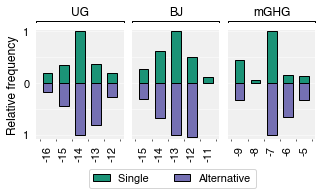

In [55]:
fig, (axug, axbj, axghg) = plt.subplots(1, 3, figsize=(5,2), sharey=True)
fig.subplots_adjust(wspace=.1)

axug.bar(ugxs, ugsingle, width=.6, facecolor=csingle, zorder=2, lw=1, edgecolor='k',
        label='Single ')
axug.bar(ugxs, ugmulti, width=.6, color=cmulti, zorder=2, lw=1, edgecolor='k',
        label='Alternative')

axbj.bar(bjxs, bjsingle, width=.6, facecolor=csingle, zorder=2, lw=1, edgecolor='k')
axbj.bar(bjxs, bjmulti, width=.6, color=cmulti, zorder=2, lw=1, edgecolor='k')

axghg.bar(ghgxs, ghgsingle, width=.6, facecolor=csingle, zorder=2, lw=1, edgecolor='k')
axghg.bar(ghgxs, ghgmulti, width=.6, color=cmulti, zorder=2, lw=1, edgecolor='k')

for ax, optipos, tit in zip([axug,axbj,axghg], [optiug,optibj,optighg], ['UG','BJ','mGHG']):
    ax.set_facecolor('#f0f0f0')
    ax.set_xlim(optipos-2.7, optipos+2.7)
    ax.set_xticks(range(optipos-2, optipos+3))
    ax.set_xticks(np.arange(optipos-2, optipos+4)-.5, minor=True)
    ax.tick_params(bottom='off', which='major')
    ax.tick_params(left='off', which='both')
    ax.set_xticklabels(-np.arange(optipos-2, optipos+3), rotation=90)
    ax.invert_xaxis()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_yticks([-1,0,1])
    ax.set_yticks([-.5,.5], minor=True)
    ax.set_yticklabels([1,0,1])
    ax.set_ylim(-1.08, 1.02)
    ax.yaxis.grid(ls='-', color='white', lw=1, which='both')
    l = lines.Line2D([optipos-2.7,optipos-2.7,optipos+2.7,optipos+2.7], 
                     [1.18, 1.2, 1.2, 1.18], linewidth=1, color='black')
    l.set_clip_on(False); ax.add_line(l)
    ax.text(optipos, 1.3, tit, fontsize=12, ha='center')
axug.legend(loc=(.6,-.45), ncol=2, prop={'size':11}, handlelength=1.5)
axug.set_ylabel('Relative frequency', fontsize=12)
#fig.savefig(resultpath + '201012_f2f__feature_multiple.pdf')#, dpi=300)

# G. Characteristics of miRNAs with nick cleavage

In [56]:
# s6 contains productive cleavage site only
for mir in nick:
    c5, c3 = s6sort.loc[[mir],["5' cleavage site","3' cleavage site"]].iloc[0]
    majorcs[mir] = clv_to_relative_pos(mir, c5, c3)
print len(majorcs)

619


In [57]:
bjcoords = {}
for mir in dcsmirs+nick:
    if mir not in strtmirs:
        bjcoords[mir] = (0,0); continue
    ps, pe = get_pre_annot(mir)[1:3]
    cs, ce = majorcs[mir]
    lsinfo = [ (s,e) for s,e in get_str_info(mir) if s<cs<e ][::-1]
    if not lsinfo:
        bjcoords[mir] = (0,0); continue
    ls1st5, ls1st3 = lsinfo[0]
    us1st3 = [ (s,e) for s,e in get_str_info(mir) if cs<=s<e ][0][1]
    init = min(cs-ls1st5, ls1st3-us1st3)
    bjs = list_basal_jcs(lsinfo, minss, 3.5, init)
    if bjs:
        bjcoords[mir] = min(bjs[::-1], key=lambda x:abs(x[0]-optibj))[1]
    else:
        bjcoords[mir] = (0,0)

In [58]:
def get_asym_count(mir):
    ps, pe = majorcs[mir]
    bs, be = bjcoords[mir]
    if not bs:
        return False
    symstr = s5.loc[mir, 'symbolized structure']
    asym5 = symstr[bs-1:ps-1].count('A')
    asym3 = symstr[pe:be].count('A')
    return (asym5, asym3)

In [59]:
xs = range(3)
data = [ [sum(get_asym_count(m)) for m in nick5 if get_asym_count(m)],
         [sum(get_asym_count(m)) for m in nick3 if get_asym_count(m)],
         [sum(get_asym_count(m)) for m in dcsmirs if get_asym_count(m)] ]
ys = map(np.average, data)
yerrs = map(sem, data)
capsize = 1.5
width = .7
lw = 1
colors = ['#c51b8a', '#c51b8a', '#ababab']
xmin, xmax = -.7, 2.6
labels = [ '5p nick', '3p nick', 'Productive' ]

In [60]:
print mannwhitneyu(data[0], data[2], alternative='two-sided')[1]
print mannwhitneyu(data[1], data[2], alternative='two-sided')[1]

7.895722676531758e-10
0.046004073906597


Text(1.5,3.8,u'*')

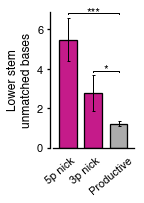

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(1.5, 2.5))
ax.bar(xs, ys, yerr=yerrs, capsize=capsize, lw=1.3, width=width, color=colors,
       edgecolor='k',error_kw={'elinewidth':1})
ax.set_xlim(xmin, xmax)
ax.set_ylabel('Lower stem\nunmatched bases', fontsize=12)
ax.set_xticks(np.array(xs)-.3)
ax.set_xticklabels(labels, rotation=40)
ax.tick_params(bottom='off')
ax.spines['bottom'].set_bounds(xmin+.1, xmax)
l = lines.Line2D([0,0,2,2], [6.75,6.8,6.8,6.75], lw=1, c='k')
l.set_clip_on(False); ax.add_line(l)
l = lines.Line2D([1,1,2,2], [3.85,3.9,3.9,3.85], lw=1, c='k')
l.set_clip_on(False); ax.add_line(l)
ax.text(1, 6.7, '***', fontsize=12, ha='center')
ax.text(1.5, 3.8, '*', fontsize=12, ha='center')
#fig.savefig(resultpath + '200908_f2g__feature_nick_v2.pdf')

# H. Characteristics of miRNAs with nick cleavage

In [62]:
uginfos, uguinfos = {}, {}
for mir in strtmirs:
    constseq = constseqs[mir].replace('T','U')
    ajst, ajen = apicaljcs[mir]
    bugseq = constseq[ajst-37:ajst-32]
    augseq = constseq[ajen-3:ajen+2]
    auguseq = constseq[ajst-3:ajst+3]
    buguseq = constseq[ajen+31:ajen+37]
    uginfos[mir] = bool(bugseq.find('UG')>=0), bool(augseq.find('UG')>=0)
    uguinfos[mir] = bool(re.search('UGU|GUG', auguseq)), bool(re.search('UGU|GUG', buguseq))

In [63]:
for mirl, label in zip([inverted,dcsmirs],['inv','prod']):
    mirl = [ m for m in mirl if m in strtmirs ]
    dug = [ len([m for m in mirl if uginfos[m][0]]), len([m for m in mirl if uginfos[m][1]]) ]
    dugu = [ len([m for m in mirl if uguinfos[m][0]]), len([m for m in mirl if uguinfos[m][1]]) ]
    print label, np.array(dug)/len(mirl), np.array(dugu)/len(mirl)

inv [0.28846154 0.42307692] [0.1025641  0.10897436]
prod [0.41682975 0.24657534] [0.33855186 0.07436399]


In [64]:
mirs = [ m for m in inverted if m in strtmirs ]
cont = [ m for m in dcsmirs if m in strtmirs ]

In [65]:
xs = [ 0, 1, 3, 4 ]
ys5 = [ len([m for m in mirs if uginfos[m][0]])/len(mirs)*100, 
        len([m for m in cont if uginfos[m][0]])/len(cont)*100,
        len([m for m in mirs if uguinfos[m][0]])/len(mirs)*100, 
        len([m for m in cont if uguinfos[m][0]])/len(cont)*100 ]
ys3 = [ len([m for m in mirs if uginfos[m][1]])/len(mirs)*100, 
        len([m for m in cont if uginfos[m][1]])/len(cont)*100,
        len([m for m in mirs if uguinfos[m][1]])/len(mirs)*100, 
        len([m for m in cont if uguinfos[m][1]])/len(cont)*100 ]
ymax = max(max(ys5), max(ys3))
xmin, xmax = -1, 4.8
lw = 1.3
#cmirs, ccont = '#454545', '#cdcdcd'
cmirs, ccont = '#d95f02', '#ababab'
labels = [ 'Inverted', 'Productive' ]

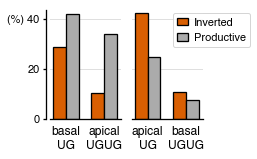

In [66]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(2.8,2), sharey=True)
fig.subplots_adjust(wspace=0.1)

for ys, ax in zip([ys5,ys3], [ax1,ax2]):
    ps = ax.bar(xs, ys, color=[cmirs,ccont]*2, lw=lw, edgecolor='k', width=1, zorder=2)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(0, ymax+1)
    ax.set_xticks([.5,3.5])
    ax.spines['bottom'].set_bounds(xmin+.3, xmax)
    sq = plt.Rectangle((xmin+.3,0), xmax-xmin-.3, ymax+1, fc='w'); ax.add_patch(sq)
    ax.yaxis.grid(clip_path=sq, ls='-')
    ax.tick_params(bottom='off')

ax2.legend(ps, labels, loc=(.6,.66), handlelength=1, handletextpad=.5, prop={'size':11})  
ax1.set_xticklabels(['basal\nUG','apical\nUGUG'], fontsize=12)
ax2.set_xticklabels(['apical\nUG','basal\nUGUG'], fontsize=12)
ax1.set_yticks([0,20,40])
ax1.set_yticklabels([0,20,'(%) 40'])
ax2.spines['left'].set_visible(False)
ax2.tick_params(left='off')
#fig.savefig(resultpath + '200908_f2h__feature_inverted.pdf')